# Bias analysis

We load the standard packages for data analysis and plotting \
[NumPy](https://numpy.org/) /
[Matplotlib](https://matplotlib.org/)

The % symbols denote a "line magic" command. For matplotlib, it will define the backend to render the plots. You may need to change the backend according to the properties of your system.
[matplotlib magic](https://ipython.readthedocs.io/en/stable/interactive/magics.html#magic-matplotlib)
[backend definition](https://matplotlib.org/stable/users/explain/figure/backends.html)

In [29]:
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib widget

The [AstroPy](https://docs.astropy.org/en/stable/index.html) package provides an extended set of tools for astronomical research, data processing, and data analysis. Here we will use the [FITS file handling](https://docs.astropy.org/en/stable/io/fits/) functionality.

In [30]:
from astropy.io import fits

## Write the FITS list files for each subdirectory

Inside the dataset folder, you can find the `bias`, `flat`, and `science` folders. \

For our analysis, we need to know the names of the files listed inside each folder, so that we can access them easily. A common solution is the use of the [`glob`](https://docs.python.org/3/library/glob.html) module (see an example [here](https://realpython.com/get-all-files-in-directory-python/). 
However, my suggestion is to write a *file list* for each kind of data, and then read the appropriate list according to your needs. \
Advantages of the suggested approach over: 
- if you need to exclude some files from the analysis (e.g., sciecne frame taken while the dome was automatically closing), you just need to edit the list file, rather then moving and deleting the FITS files themselves. 
- you can easily keep track of the files excluded from the analysis without altering the orignal dataset 
- you have to download the dataset again (e.g. you overwrite all the original FITS files by mistake), you just need to save the list files before deleting and downloading the dataset folder again.

To write the list, move inside each folder and use the `ls` command - note that all the AFOSC files will start with the letter A

```bash
cd group00_HAT-P-44_20210413
cd bias
ls A*.fits > bias.list 
cd ../flat
ls A*.fits > flat.list 
cd ../science
ls A*.fits > science.list 
cd ~/TASTE_dataset/
```

Keep in mind that you will need to include the path of the directory when accessing the data using the FITS names in the list.\
After preparing the list, you can load them using the [numpy.genfromtxt](https://numpy.org/doc/stable/reference/generated/numpy.genfromtxt.html) function.

In [31]:
bias_list = np.genfromtxt('../bias/bias.list', dtype=str)
print(bias_list)

['AF580596.fits' 'AF580597.fits' 'AF580598.fits' 'AF580599.fits'
 'AF580600.fits' 'AF580601.fits' 'AF580602.fits' 'AF580603.fits'
 'AF580604.fits' 'AF580605.fits' 'AF580606.fits' 'AF580607.fits'
 'AF580608.fits' 'AF580609.fits' 'AF580610.fits' 'AF580611.fits'
 'AF580612.fits' 'AF580613.fits' 'AF580614.fits' 'AF580615.fits'
 'AF580616.fits' 'AF580617.fits' 'AF580618.fits' 'AF580619.fits'
 'AF580620.fits' 'AF580621.fits' 'AF580622.fits' 'AF580623.fits'
 'AF580624.fits' 'AF580625.fits']


## Extract information from a FITS file

We use the standard `astropy.io.fits` routines to
1) open a single FITS file and save it into a variable named `bias00_fits`
2) store the Primary HDU of the fits file into a variable named `bias00_hdu`
3) print the header of the Primary HDU using the corresponding `astropy.io.fits` method


In [32]:
bias00_fits = fits.open('../bias/'+bias_list[0])
bias00_hdu = bias00_fits[0]
print(bias00_hdu)

In [33]:
bias00_hdu.header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                   16 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                  521 / length of data axis 1                          
NAXIS2  =                  222 / length of data axis 2                          
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
BZERO   =                32768 / offset data range to that of unsigned short    
BSCALE  =                    1 / default scaling factor                         
DATE    = '2019-12-29T23:10:36' / file creation date (YYYY-MM-DDThh:mm:ss UT)   
FILENAME= 'AF580596.fits'      / Original file name                             
TIMESYS = 'UTC     '        

We retrieve some useful information from the header, and we print them using the `String format() Method`
You can find more information regarding fancier formatting in the [official Python3 documentation page](https://docs.python.org/3/tutorial/inputoutput.html). 

Question: what are the units of ReadOut Noise (RON) and Gain? We can get it from the comments in the header using the `comments` attribute of the `header` (Note: some tweaking in formatting is required to show the output nicely)

Question: does the date of your bias correspond to the night of your science dataset? Convert the Julian date to Universal Time to know your answer [here](https://www.aavso.org/jd-calculator) - YES


In [34]:
bias00_time = bias00_hdu.header['JD']
bias00_airmass = bias00_hdu.header['AIRMASS']

bias00_gain  = bias00_hdu.header['GAIN']
bias00_gain_comment = bias00_hdu.header.comments['GAIN']

bias00_readout_noise = bias00_hdu.header['RDNOISE']
bias00_ron_comment = bias00_hdu.header.comments['RDNOISE']

print('Julian date      : {0:12.6f} JD'.format(bias00_time))
print('CCD Gain         : {0:4.2f} {1:.8s}'.format(bias00_gain,bias00_gain_comment))
print('CCD Readout noise: {0:4.2f} {1:.3s}'.format(bias00_readout_noise,bias00_ron_comment))

#print(time, airmass, gain, readout_noise)

Julian date      : 2458847.465683 JD
CCD Gain         : 1.91 [e/ADU] 
CCD Readout noise: 7.10 [e]


## Understanding the shape of an image/array in Python

To compute the median of all our frames, we need to open and save them somewhere in the Random Access Memory of the computer. That means that we have to create a `buffer` or `stack` with enough space (=correct dimensions) to keep all the images.

But how are the images saved into the memory of the computer?
The header of the FITS files can tell us the shape of the picture, i.e., the `NAXIS1` and `NAXIS2`, which we may expect to be the length of the horizontal axis (number of columns) and the length of the vertical axis (number of row), respectively.

In [35]:
bias00_naxis1 =  bias00_hdu.header['NAXIS1']
bias00_naxis2 =  bias00_hdu.header['NAXIS2']
print('Shape of the FITS image from the header      : {0:4d} x {1:4d}'.format(bias00_naxis1, bias00_naxis2))


Shape of the FITS image from the header      :  521 x  222


The shape of the array in the memory of the computer, however, may be different from the size of the image as we *perceive* it when we inspect it visually. The difference depends if the programming language is interpreting our image as a matrix or not.
- For CCD images, the first index indicates the x coordinate (i.e., the column), and the second indicates the y position (i.e., the row)
- For matrices in mathematical notation, the first index indicates the row, and the second indicates the column

See for example [row- or column-major order](https://en.wikipedia.org/wiki/Row-_and_column-major_order).

When we use the `data` attribute to extract the FITS data and save it into an object, the resulting array may the shape `NAXIS1 x NAXIS2` or `NAXIS2 x NAXIS1` depending if we are using the usual coordinate system for a CCD image  or for a matrix respectivly.

The only way to be dure to do things correctly, is to actually check the size of our array using the [`numpy.shape` function](https://numpy.org/doc/stable/reference/generated/numpy.shape.html)

In [36]:

bias00_data = bias00_hdu.data * bias00_gain
bias00_nparray_dim00, bias00_nparray_dim01 = np.shape(bias00_data)
print('Shape of the NumPy array extracted by astropy: {0:4d} x {1:4d}'.format(bias00_nparray_dim00, bias00_nparray_dim01))
print('Our image is saved as a ', type(bias00_data))


Shape of the NumPy array extracted by astropy:  222 x  521
Our image is saved as a  <class 'numpy.ndarray'>


We can now see how to interpret avalue int he position `bias00_data[i,j]`:
1) i is the index of the row where our pixel is located
2) j is the index of the column where our pixel is located
So the shape of our array is inverted with respect to the coordinate systems defined in the FITS file. This is fine, if we are always self-consistent with this notation

## Save the bias frames into a 3D array


In [37]:
n_images = len(bias_list)
bias00_nparray_dim00, bias00_nparray_dim01 = np.shape(bias00_data)


stack = np.empty([n_images, bias00_nparray_dim00, bias00_nparray_dim01])

for i_bias, bias_name in enumerate(bias_list):
    bias_temp = fits.open('../bias/'+bias_name)
    stack[i_bias,:,:] = bias_temp[0].data * bias_temp[0].header['GAIN']
    bias_temp.close()

In [38]:
median_bias = np.median(stack, axis=0)                   #median pixel value for each pixel of the master bias
median_error = np.std(stack, axis=0)/(n_images)**0.5     #error for each pixel of the master bias
median_pixels_error = np.median(median_error)            #median error for the master bias
np.shape(median_bias)

print(median_pixels_error)
print(np.std(median_bias))
print(median_error)
print(median_bias.shape)

1.3101521313982625
2.0665820198187754
[[1.24739016 1.15334529 1.23432356 ... 1.28516283 1.11134357 1.32634644]
 [1.41262546 1.29067058 1.34133846 ... 1.33851501 1.35202379 1.19001612]
 [1.35656322 1.21579442 1.38143463 ... 1.49225576 1.16494343 1.27312109]
 ...
 [1.12721769 1.58528722 1.47929698 ... 1.52693852 1.1691114  1.57111825]
 [1.37481677 1.40090781 1.08102175 ... 1.22597602 1.22111715 1.0603256 ]
 [1.1413334  1.12601839 1.308914   ... 1.23240644 1.20440552 1.2765127 ]]
(222, 521)


### Plotting a single bias and a median bias
We use the `utility matplotlib.pyplot.subplots` to include two plots in the same image. The first two values identify the number of rows andcolumns of the subplot grid (in the example, 2 plots one on top of the other, spanning the entire horizontal range). We pass the argument `figsize=(8,6)` to define the width and height of the plot, in inches. In geenral, we can pass every argument accepted by matplotlib.pyplot.figure.

To plot a single frame, we can use the function `matplotlib.pyplot.imshow`
We can specify the lower value `vmin` and the upper value `vmax` covered by the colormap. We use the same values for the two frames to refer to a single colorbar. Note that the values are automatically assigned by taking the minimum and maximum values, respectively, if they are not specfified.
We also need to change the origin of the plot by specifying `origin='lower'` to match the reference frame of the FITS standard.

We save each image to a new variable, `im1` and `im2`, so that we can use one of the image as reference for `matplotlib.pyplot.colorbar`

Finally, we specify the labels for each plot.

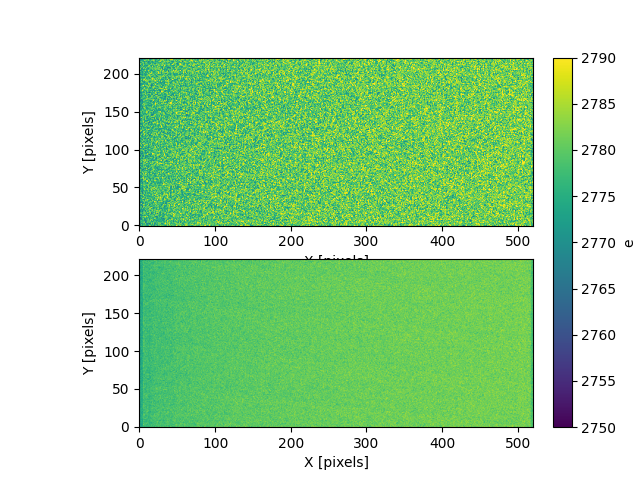

In [39]:
fig, ax = plt.subplots(2,1) # Caution, figsize will also influence positions.
im1 = ax[0].imshow(bias00_data, vmin = 2750, vmax =2790, origin='lower')
im2 = ax[1].imshow(median_bias, vmin = 2750, vmax =2790, origin='lower')

# add the colorbar using the figure's method,
# telling which mappable we're talking about and
# which axes object it should be near
cbar = fig.colorbar(im1, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label("e")

ax[0].set_xlabel('X [pixels]')
ax[0].set_ylabel('Y [pixels]')

ax[1].set_xlabel('X [pixels]')
ax[1].set_ylabel('Y [pixels]')
plt.show()

### Statistical analysis of the bias
A bias frame comprises two primary components: the offset introduced by the electronics, and supposedly constant across the frame, and the readout noise. We can then use the bias to extract some infomration regarding the readout noise.

First of all, let's verify if the bias is indeed constant across the frame. Visually, we can highlight any variation in the bias by restricting the range of the colorbar. Analytically, we can compute the average across each column and plot the results as a function of the column number. We chose this way because the plot highlights a more substantial variation across the horizontal direction.

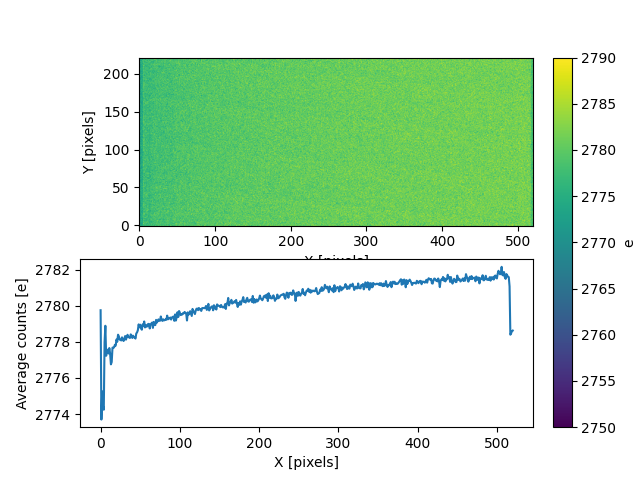

In [40]:
fig, ax = plt.subplots(2,1) #figsize=(8,6)) Caution, figsize will also influence positions.
im1 = ax[0].imshow(median_bias, vmin = 2750, vmax =2790, origin='lower')
median_column = np.average(median_bias, axis=0)
im2 = ax[1].plot(median_column)

# add the colorbar using the figure's method,
# telling which mappable we're talking about and
# which axes object it should be near
cbar = fig.colorbar(im1, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label("e")

ax[0].set_xlabel('X [pixels]')
ax[0].set_ylabel('Y [pixels]')

ax[1].set_xlabel('X [pixels]')
ax[1].set_ylabel('Average counts [e]')
plt.show()

Knowing that the bias is not constant, we can still compare the readout noise as reported in the header of the fits frame and the standard deviation directly computed of the data if we restrict ourself to a small range in columns.

In [41]:
starting_column= 300
ending_column = 350
print('Readout noise                  : {0:4.2f} e'.format(bias00_readout_noise))
print('STD single frame               : {0:4.2f} e'.format(np.std(bias00_data[:,starting_column:ending_column])))

Readout noise                  : 7.10 e
STD single frame               : 7.49 e


The values above refer to the readout noise of a single exposure. The median bias is the combination of 30 individual frames, so the associated error will be smaller than the one coming with a single frame.

Suppose we approximate the median with the average function. In that case, we can use the standard equation for error propagation to compute the associated error to the median bias, assuming that all the pixels from each bias are affected by the same error. The resulting value will change slightly if we use the readout noise as an estimate of the error associated with each image (case 1) or if we use the standard deviation of a bias frame (case 2)

In [42]:
expected_noise_medianbias = bias00_readout_noise/np.sqrt(n_images)
print('1) Expected noise of median bias  : {0:4.2f} e'.format(expected_noise_medianbias))
expected_std_medianbias = np.std(bias00_data[:,starting_column:ending_column])/np.sqrt(n_images)
print('2) Expected STD of median bias    : {0:4.2f} e'.format(expected_std_medianbias))

1) Expected noise of median bias  : 1.30 e
2) Expected STD of median bias    : 1.37 e


Alternatively, we can compute the error associated with the median bias from the data. We can use the standard deviation of the median bias, selecting the same range in columns as done before (case 3), or we can compute the standard deviation of each pixel across all the frames, divide by the square root of the number of images, and finally calculate the median of all these values. We perform the last step to have one value for the error associated with the median bias, but in principle, we could keep the entire frame.

In [43]:
measured_std_medianbias = np.std(median_bias[:,starting_column:ending_column])
print('Measured STD of median bias    : {0:4.2f} e'.format(measured_std_medianbias))
median_error = np.std(stack, axis=0) /np.sqrt(n_images)
median_pixel_error = np.median(median_error)
print('Median STD of each pixel       : {0:4.2f} e'.format(median_pixel_error))

Measured STD of median bias    : 1.69 e
Median STD of each pixel       : 1.31 e


We can see that the standard deviation computed on the median bias is slighlty higher than the associated error computed through the other techniques. We already analyzed the origin of this disagreement.

Finally, we can plot the distribution of the error associated to each pixel of the median bias with the different estimates of the error. This plot should guide you towards the best choice fro the error to be associated to the median bias.

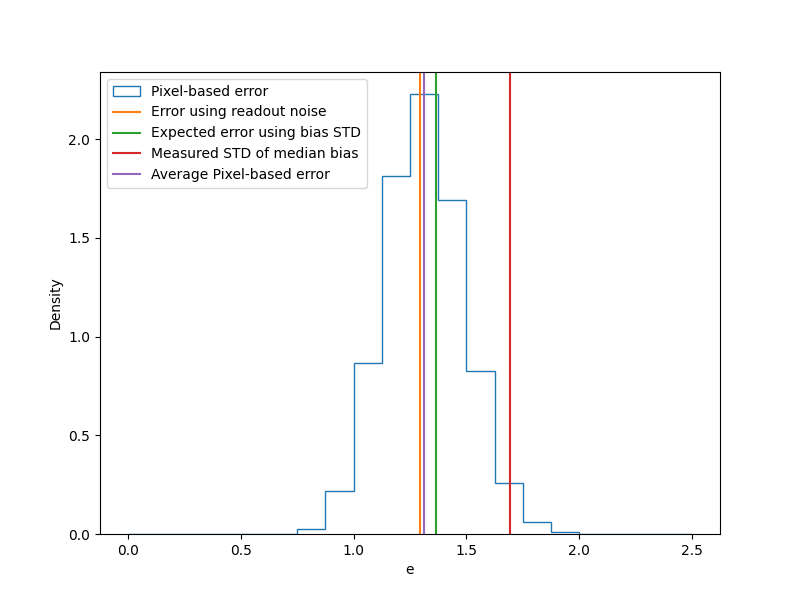

In [44]:
# Standard deviation of each pixel
STD_pixel = np.std(stack, axis=0) # 

plt.figure(figsize=(8,6))
plt.hist(median_error.flatten(), bins=20, range=(0,2.5), density=True, histtype='step', label='Pixel-based error')
plt.axvline(expected_noise_medianbias, c='C1', label='Error using readout noise')
plt.axvline(expected_std_medianbias, c='C2', label='Expected error using bias STD')
plt.axvline(measured_std_medianbias, c='C3', label='Measured STD of median bias')
plt.axvline(median_pixel_error, c='C4', label='Average Pixel-based error')
plt.xlabel('e')
plt.ylabel('Density')
plt.legend()
plt.show()

In [45]:
np.sqrt(n_images)
print('STD single frame               : {0:4.2f} e'.format(np.std(bias00_data[:,200:400])))
print('Readout noise                  : {0:4.2f} e'.format(bias00_readout_noise))
print('Expected STD of master bias    : {0:4.2f} e'.format(np.std(bias00_data[:,200:400])/np.sqrt(n_images)))
print('Expected noise of master bias  : {0:4.2f} e'.format(bias00_readout_noise/np.sqrt(n_images)))
print('Measured STD of master bias    : {0:4.2f} e'.format(np.std(median_bias[:,200:400])))

STD single frame               : 7.40 e
Readout noise                  : 7.10 e
Expected STD of master bias    : 1.35 e
Expected noise of master bias  : 1.30 e
Measured STD of master bias    : 1.72 e


In [46]:
# Save a dictionary/object into a pickle file.
import pickle
  # create a dictionary
pickle.dump(median_bias, open("output_files/median_bias.p", "wb"))
pickle.dump(median_error, open('output_files/median_bias_error.p', 'wb'))
pickle.dump(median_pixels_error, open('output_files/median_bias_error_value.p', 'wb'))
pickle.dump(stack, open("output_files/stack_bias.p", "wb")) 